In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from scipy import stats
warnings.filterwarnings(action='ignore')
%matplotlib inline
%pylab
%config InlineBackend.figure_format = 'retina'

temporada = 2017

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


#### Pasos para el cálculo del "Wins Produced"

Para el cálculo de esta medida de valoración de los jugadores, vamos a partir de dos csv, uno con datos a nivel de encuentro, y otro con datos a nivel de jugador. Ambos contienen la información del boxscore de cada encuentro, pero a distintos niveles de agrupación.

Con este primer csv obtendremos la influencia de cada métrica del boxscore sobre el porcentaje de victorias a través de un modelo de regresión.

Posteriormente, utilizaremos esa influencia que hemos obtenido, para calcular la medida de valoración "Wins Produced" a nivel de jugador en cada encuentro. Para este cálculo utilizaremos el segundo csv, que contiene los datos a nivel de jugador.

Una vez obtenido el "Wins Produced", lo utilizaremos para generar la nueva variable que incluiremos en nuestro modelo de predicción del resultado de los partidos.

Será una variable de calidad de los jugadores que participan en el encuentro, basada en una media de esta variable en lo que va de temporada para dichos jugadores.


### Creamos el modelo para el cálculo del Wins Produced

In [2]:
# Importamos los datos con información de los partidos desde la visión de local

partidos = pd.read_csv('input.csv')
partidos = partidos.drop_duplicates()
partidos = partidos.dropna()

# Modificamos el formato de algunas variables 

partidos = partidos.drop(columns=['Date'])
partidos['Date']=partidos['ID Partido'].str.extract(pat='(2\w{7})')

partidos['Year'] = partidos['Year'].astype(int)
partidos['Season'] = partidos['Season'].astype(int)
partidos['Points'] = partidos['Points'].astype(int)
partidos['Opponent_Points'] = partidos['Opponent_Points'].astype(int)
partidos['Result_local'] = np.where(partidos['Points'] > partidos['Opponent_Points'], 'W', 'L')
partidos['Result_visitor'] = np.where(partidos['Points'] < partidos['Opponent_Points'], 'W', 'L')


# Seleccionamos las temporadas a incluir en nuestro modelo

temporada = 2015

partidos = partidos.loc[partidos['Season'] > temporada]


#### Creamos el DF para la regresión a nivel de equipo ####

# Dividimos el DF en dos para tenerlo a nivel de equipo, es decir, una fila con el dato del local y otra con el visitante

partidos_visitor = partidos.loc[:, ['Date', 'Year', 'Season', 'ID Partido', 'local_team', 'visitor_team', 'Opponent_Points', 
           'Result_visitor', 'visitor_fg', 'visitor_fga', 'visitor_fg_pct', 'visitor_fg3', 'visitor_fg3a','visitor_fg3_pct',
           'visitor_ft', 'visitor_fta', 'visitor_ft_pct', 'visitor_orb', 'visitor_drb', 'visitor_ast', 'visitor_stl', 
           'visitor_blk', 'visitor_tov', 'visitor_pf', 'visitor_pts', 'visitor_Conf_position', 'visitor_Win', 'visitor_Lose', 
           'visitor_Percentagewl', 'visitor_Dif_leader', 'visitor_Home_win', 'visitor_Home_lose', 'visitor_Away_win', 
           'visitor_Away_lose', 'visitor_Div_win', 'visitor_Div_lose', 'visitor_Cnf_win', 'visitor_Cnf_lose', 'visitor_Icf_win',
           'visitor_Icf_lose', 'local_ft', 'local_fg3', 'local_fg', 'local_tov', 'Sueldo visitante', 'Visitor_Division', 
           'Visitor_Conferencia', 'visitor_trb', 'VISITANTE_Ultimos10Victorias', 'VISITANTE_Ultimos10Derrotas', 
           'VISITANTE_Racha', 'VISITOR_AWS_MEDIO_AGRUPADO']]


# Eliminamos los datos del visitante para el DF del local

partidos = partidos.drop(columns=['Opponent_Points', 'Result_visitor', 'Result', 'visitor_fga', 'visitor_fg_pct',
           'visitor_fg3a','visitor_fg3_pct', 'visitor_fta', 'visitor_ft_pct', 'visitor_orb', 'visitor_drb', 
           'visitor_ast', 'visitor_stl', 'visitor_blk', 'visitor_pf', 'visitor_pts', 'visitor_Conf_position',
           'visitor_Win', 'visitor_Lose', 'visitor_trb', 'visitor_Percentagewl', 'visitor_Dif_leader', 'visitor_Home_win',
           'visitor_Home_lose', 'visitor_Away_win','visitor_Away_lose', 'visitor_Div_win', 'visitor_Div_lose','visitor_Cnf_win',
           'visitor_Cnf_lose', 'visitor_Icf_win', 'visitor_Icf_lose', 'Sueldo visitante', 'Visitor_Division',
           'Visitor_Conferencia', 'VISITANTE_Ultimos10Victorias', 'VISITANTE_Ultimos10Derrotas', 'VISITANTE_Racha',
            'VISITOR_AWS_MEDIO_AGRUPADO'])


# Unificamos los nombres de las variables en ambos DF

partidos = partidos.rename(columns=lambda x: x.replace('local_', ''))
partidos = partidos.rename(columns=lambda x: x.replace('LOCAL_', ''))
partidos = partidos.rename(columns=lambda x: x.replace('Local_', ''))

partidos.rename(columns={'Result_local': 'Result', 'team': 'team_PoV', 'visitor_team': 'Opponent_team', 
                         'visitor_ft': 'FTM_opp', 'visitor_fg': 'FG_opp', 'visitor_fg3': '3FGM_opp', 'visitor_tov': 'TO_opp',
                         'Sueldo local': 'Sueldo'}, inplace=True)


partidos_visitor = partidos_visitor.rename(columns=lambda x: x.replace('visitor_', ''))
partidos_visitor = partidos_visitor.rename(columns=lambda x: x.replace('VISITANTE_', ''))
partidos_visitor = partidos_visitor.rename(columns=lambda x: x.replace('Visitor_', ''))
partidos_visitor = partidos_visitor.rename(columns=lambda x: x.replace('VISITOR_', ''))

partidos_visitor.rename(columns={'Result_visitor': 'Result', 'team': 'team_PoV', 'local_team': 'Opponent_team', 
                                 'Opponent_Points': 'Points', 'local_ft': 'FTM_opp', 'local_fg': 'FG_opp', 
                                 'local_fg3': '3FGM_opp', 'local_tov': 'TO_opp', 'Sueldo visitante':'Sueldo'}, inplace=True)


# Unimos ambos DF verticamente 

partidos_union = pd.concat([partidos, partidos_visitor])


# Creamos las variables necesarias para el cálculo

partidos_union['2FGM'] = partidos_union['fg'] - partidos_union['fg3']
partidos_union['FGMS'] = partidos_union['fga'] - partidos_union['fg']
partidos_union['FTMS'] = partidos_union['fta'] - partidos_union['ft']
partidos_union['2FGM_opp'] = partidos_union['FG_opp'] - partidos_union['3FGM_opp']

partidos_union.rename(columns={'fg3': '3FGM', 'ft': 'FTM', 'orb': 'REBO', 'drb': 'REBD', 'tov': 'TO', 'stl': 'STL', 
                                 'blk': 'BLK'}, inplace=True)


# Generamos la variable dummy Win que tomará valor 1 si el equipo ganó el encuentro

partidos_union['Win'] = np.where(partidos_union['Result'] == 'W', 1, 0)


# Creamos un DF con las variables del modelo

partidos_union_reg = partidos_union.loc[:, ['3FGM', '2FGM', 'FTM', 'FGMS', 'FTMS', 'REBO', 'REBD', 'TO', 'STL', 
                                            'FTM_opp', 'BLK', '3FGM_opp', '2FGM_opp', 'TO_opp', 'Win', 'Percentagewl']]

print(partidos_union_reg.head(5))


#### Generamos el modelo de regresión ####

# Creamos las variables X e Y del modelo

x = partidos_union_reg.loc[:, ['3FGM', '2FGM', 'FTM', 'FGMS', 'FTMS', 'REBO', 'REBD', 'TO', 'STL', 
                                            'FTM_opp', 'BLK',  '3FGM_opp', '2FGM_opp', 'TO_opp']]

y = partidos_union_reg.loc[:, ['Percentagewl']]


from statsmodels.api import OLS

model = OLS(y,x).fit()

print('\n',model.summary())

var = pd.DataFrame(dict(zip(x.columns,model.params)),index=[0]).T

   3FGM  2FGM  FTM  FGMS  FTMS  REBO  REBD  TO  STL  FTM_opp  BLK  3FGM_opp  \
0     2     8   11    19     5     2    15   8    1       13    2         3   
2     3    16   13    22     2     6    17   8    5        8    2         3   
3     4    15    2    21     2     5    17   9    2        6    7         3   
4     3    14    6    33     5     7    20   7    6        8    6         4   
5     6    16    7    22     4     7    12   6    1       12    4         3   

   2FGM_opp  TO_opp  Win  Percentagewl  
0        14       1    0           0.0  
2        16       9    0           0.0  
3        18       4    0           0.0  
4        16       8    0           0.0  
5        21       4    0           0.0  

                             OLS Regression Results                            
Dep. Variable:           Percentagewl   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   

In [5]:
y1 = partidos_union_reg.loc[:, ['Win']]


model1 = OLS(y1,x).fit()

print('\n',model1.summary())


                             OLS Regression Results                            
Dep. Variable:                    Win   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     1519.
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        18:25:22   Log-Likelihood:                -7041.2
No. Observations:               12332   AIC:                         1.411e+04
Df Residuals:                   12318   BIC:                         1.421e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
3FGM           0.0751      0.002     31.221      0

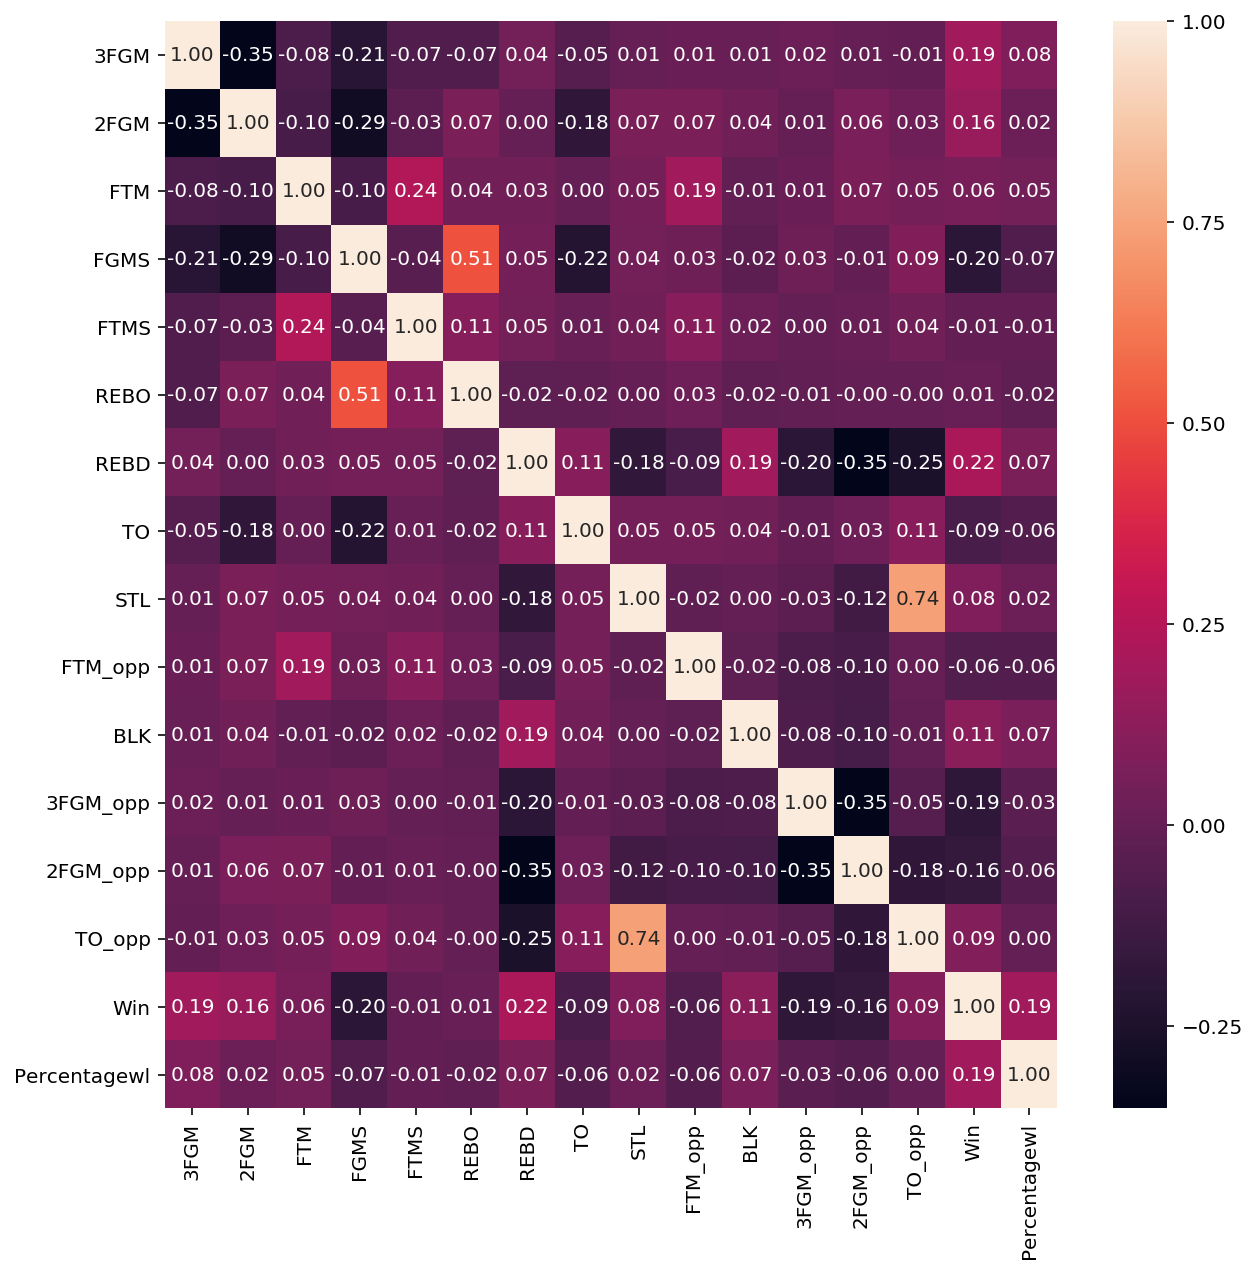

In [3]:
plt.figure(figsize=(10,10))
sns.heatmap(partidos_union_reg.corr(), annot=True, fmt='.2f')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D5289074E0>,
      dtype=object)

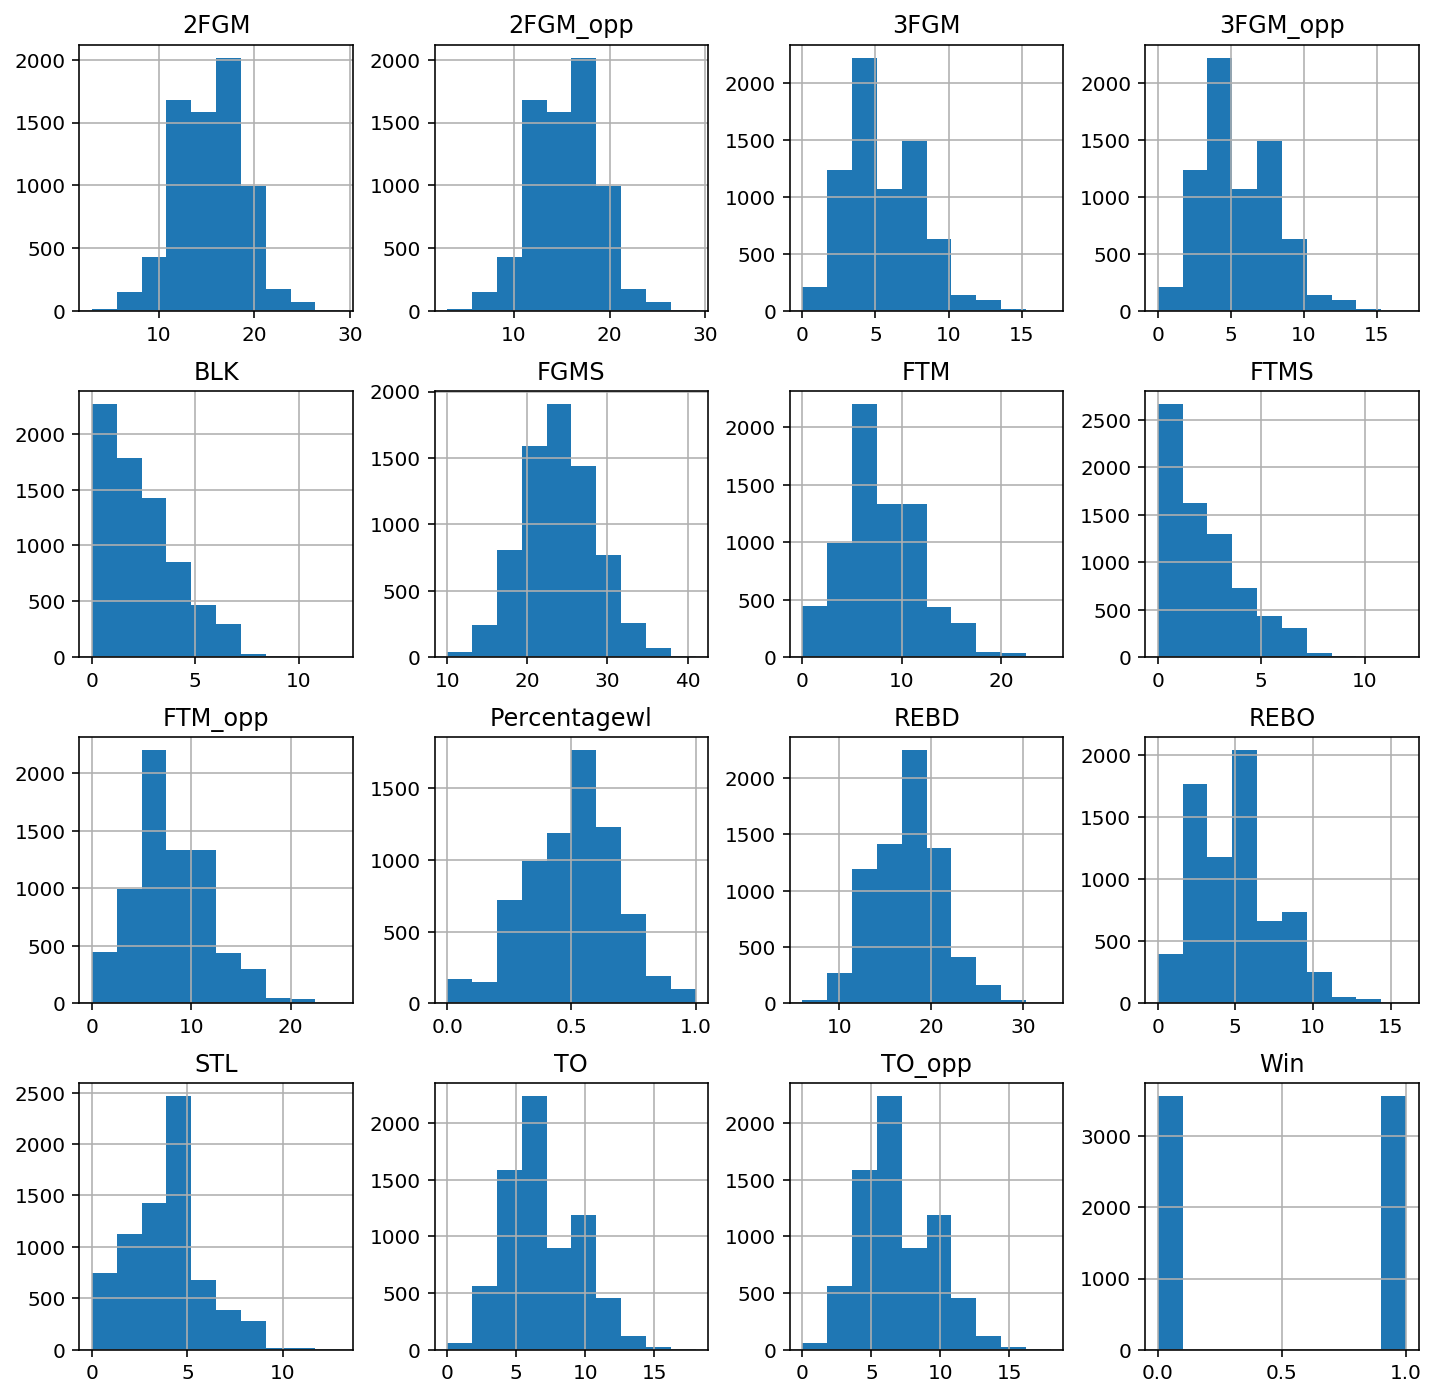

In [4]:
partidos_union_reg.hist(figsize = (12, 12))

### Calculamos el Wins Produced con las ponderaciones obtenidas con el modelo de regresión

### Calculamos el WP a nivel de jugador en cada encuentro

In [19]:
# Importamos el csv con la información de los partidos a nivel de jugador

jugadores = pd.read_csv('Stats_jugadores_27_04_20.csv')
jugadores = jugadores.dropna()

# Modificamos el formato de algunas variables

jugadores['Year'] = jugadores['Year'].astype(int)
jugadores['Season'] = jugadores['Season'].astype(int)

jugadores['Team Points'] = jugadores['Team Points'].astype(int)
jugadores['Opponent Points'] = jugadores['Opponent Points'].astype(int)
jugadores['Result'] = np.where(jugadores['Team Points'] > jugadores['Opponent Points'], 'W', 'L')

jugadores = jugadores.drop(columns=['Date'])
jugadores['Date']=jugadores['ID Partido'].str.extract(pat='(2\w{7})')


# Seleccionamos las temporadas a incluir en nuestro modelo

jugadores_WP = jugadores.loc[jugadores['Season'] > temporada]


# Creamos las variables necesarias para el cálculo

jugadores_WP['2FGM'] = jugadores_WP['Tiros anotados'] - jugadores_WP['Tiros de tres anotados']
jugadores_WP['FGMS'] = jugadores_WP['Tiros intentados'] - jugadores_WP['Tiros anotados']
jugadores_WP['FTMS'] = jugadores_WP['Tiros libres intentados'] - jugadores_WP['Tiros libres anotados']


# Renombramos las variables que vamos a usar para nuestro calculo del AWS

jugadores_WP.rename(columns={'Tiros de tres anotados': '3FGM', 'Tiros libres anotados': 'FTM', 'Rebotes ofensivos': 'REBO',
                                 'Rebotes defensivo': 'REBD', 'Robos': 'STL', 'Tapones': 'BLK', 'Perdidas': 'TO'}, inplace=True)


# Generamos la variable de faltas del total del equipo para obtener el porcentaje de faltas de cada jugador sobre ese total

jugadores_WP_Faltas = jugadores_WP.groupby(['ID Partido', 'Team'], as_index=False).agg({'Faltas':'sum',
                                                                                        'TO':'sum',
                                                                                        'REBD':'sum',
                                                                                        'REBO':'sum',
                                                                                        'BLK':'sum'})
                                                                                       

jugadores_WP_df_jugador = pd.merge(jugadores_WP, jugadores_WP_Faltas, how='left', on=['ID Partido', 'Team'])

jugadores_WP_df_jugador.rename(columns={'Faltas_x': 'Faltas jugador', 'Faltas_y': 'Faltas equipo', 'TO_x': 'TO', 'TO_y': 'TOTM',
                                        'REBD_x': 'REBD', 'REBD_y': 'REBDTM', 'REBO_x': 'REBO', 'REBO_y': 'REBOTM',
                                        'BLK_x': 'BLK', 'BLK_y': 'BLKTM'}, inplace=True)

jugadores_WP_df_jugador['Pct faltas jugador'] = jugadores_WP_df_jugador['Faltas jugador'] / jugadores_WP_df_jugador['Faltas equipo']


# Generamos las variables *_opp con los datos realizados del total del equipo oponente

jugadores_WP_df_opp = jugadores_WP_df_jugador.groupby(['ID Partido', 'Local'], as_index=False).agg({'FTM':'sum',
                                                                                                    '3FGM':'sum',
                                                                                                    '2FGM':'sum',
                                                                                                    'TO':'sum'})

jugadores_WP_df_opp['Local'] = np.where(jugadores_WP_df_opp['Local'] == True, 'False', 'True')

jugadores_WP_df_opp.rename(columns={'FTM': 'FTM_opp_team', '3FGM': '3FGM_opp', '2FGM': '2FGM_opp', 'TO':'TO_opp'}, inplace=True)

jugadores_WP_df_jugador['Local'] = jugadores_WP_df_jugador['Local'].astype(str)

jugadores_WP_df_jugador = pd.merge(jugadores_WP_df_jugador, jugadores_WP_df_opp, how='left', on=['ID Partido', 'Local'])


# Obtenemos el DF final para el cálculo del WP

jugadores_WP_df_jugador['FTM_opp'] = jugadores_WP_df_jugador['Pct faltas jugador'] * jugadores_WP_df_jugador['FTM_opp_team']

jugadores_WP_df_jugador

,Team,Season,Year,ID Partido,Local,Opponent,Team Points,Opponent Points,Result,Name,...,TOTM,REBDTM,REBOTM,BLKTM,Pct faltas jugador,FTM_opp_team,3FGM_opp,2FGM_opp,TO_opp,FTM_opp
0,Philadelphia 76ers,2016,2015,/boxscores/201510280BOS.html,False,Boston Celtics,95,112,L,"Okafor,Jahlil",...,22.0,32.0,14.0,6.0,0.181818,26.0,8.0,31.0,17.0,4.727273
1,Philadelphia 76ers,2016,2015,/boxscores/201510280BOS.html,False,Boston Celtics,95,112,L,"Canaan,Isaiah",...,22.0,32.0,14.0,6.0,0.000000,26.0,8.0,31.0,17.0,0.000000
2,Philadelphia 76ers,2016,2015,/boxscores/201510280BOS.html,False,Boston Celtics,95,112,L,"Thompson,Hollis",...,22.0,32.0,14.0,6.0,0.272727,26.0,8.0,31.0,17.0,7.090909
3,Philadelphia 76ers,2016,2015,/boxscores/201510280BOS.html,False,Boston Celtics,95,112,L,"Noel,Nerlens",...,22.0,32.0,14.0,6.0,0.181818,26.0,8.0,31.0,17.0,4.727273
4,Philadelphia 76ers,2016,2015,/boxscores/201510280BOS.html,False,Boston Celtics,95,112,L,"Sampson,JaKarr",...,22.0,32.0,14.0,6.0,0.045455,26.0,8.0,31.0,17.0,1.181818
5,Philadelphia 76ers,2016,2015,/boxscores/201510280BOS.html,False,Boston Celtics,95,112,L,"McConnell,T.J.",...,22.0,32.0,14.0,6.0,0.181818,26.0,8.0,31.0,17.0,4.727273
6,Philadelphia 76ers,2016,2015,/boxscores/201510280BOS.html,False,Boston Celtics,95,112,L,"Grant,Jerami",...,22.0,32.0,14.0,6.0,0.090909,26.0,8.0,31.0,17.0,2.363636
7,Philadelphia 76ers,2016,2015,/boxscores/201510280BOS.html,False,Boston Celtics,95,112,L,"Holmes,Richaun",...,22.0,32.0,14.0,6.0,0.045455,26.0,8.0,31.0,17.0,1.181818
8,Philadelphia 76ers,2016,2015,/boxscores/201510280BOS.html,False,Boston Celtics,95,112,L,"Wood,Christian",...,22.0,32.0,14.0,6.0,0.000000,26.0,8.0,31.0,17.0,0.000000
9,Philadelphia 76ers,2016,2015,/boxscores/201510300PHI.html,True,Utah Jazz,71,99,L,"Okafor,Jahlil",...,18.0,31.0,8.0,5.0,0.136364,20.0,7.0,29.0,7.0,2.727273


### Calculamos el Wins Produced a nivel de jugador en cada partido

In [20]:
# Calculamos el Wins Produced

jugadores_WP_df_jugador['WP'] = var[0]['3FGM'] * jugadores_WP_df_jugador['3FGM'] + var[0]['2FGM'] * jugadores_WP_df_jugador['2FGM'] + \
                + var[0]['FTM'] * jugadores_WP_df_jugador['FTM'] + var[0]['FGMS'] * jugadores_WP_df_jugador['FGMS'] + \
                + var[0]['FTMS'] * jugadores_WP_df_jugador['FTMS'] + var[0]['REBO'] * jugadores_WP_df_jugador['REBO'] + \
                + var[0]['REBD'] * jugadores_WP_df_jugador['REBD'] + var[0]['TO'] * jugadores_WP_df_jugador['TO'] + \
                + var[0]['STL'] * jugadores_WP_df_jugador['STL'] + var[0]['FTM_opp'] * jugadores_WP_df_jugador['FTM_opp'] + \
                + var[0]['BLK'] * jugadores_WP_df_jugador['BLK']

jugadores_WP_df_jugador['WP_team'] = var[0]['3FGM_opp'] * jugadores_WP_df_jugador['3FGM_opp'] + \
            + var[0]['2FGM_opp'] * jugadores_WP_df_jugador['2FGM_opp'] + var[0]['TO_opp'] * jugadores_WP_df_jugador['TO_opp'] + \
            + var[0]['TO'] * jugadores_WP_df_jugador['TOTM'] + var[0]['REBO'] * jugadores_WP_df_jugador['REBOTM'] + \
            + var[0]['REBD'] * jugadores_WP_df_jugador['REBDTM'] + var[0]['BLK'] * jugadores_WP_df_jugador['BLKTM']

jugadores_WP_df_jugador['WP_adj'] = jugadores_WP_df_jugador['WP'] + jugadores_WP_df_jugador['WP_team']

jugadores_WP_df_jugador

,Team,Season,Year,ID Partido,Local,Opponent,Team Points,Opponent Points,Result,Name,...,BLKTM,Pct faltas jugador,FTM_opp_team,3FGM_opp,2FGM_opp,TO_opp,FTM_opp,WP,WP_team,WP_adj
0,Philadelphia 76ers,2016,2015,/boxscores/201510280BOS.html,False,Boston Celtics,95,112,L,"Okafor,Jahlil",...,6.0,0.181818,26.0,8.0,31.0,17.0,4.727273,0.241996,-0.073734,0.168262
1,Philadelphia 76ers,2016,2015,/boxscores/201510280BOS.html,False,Boston Celtics,95,112,L,"Canaan,Isaiah",...,6.0,0.000000,26.0,8.0,31.0,17.0,0.000000,0.209572,-0.073734,0.135838
2,Philadelphia 76ers,2016,2015,/boxscores/201510280BOS.html,False,Boston Celtics,95,112,L,"Thompson,Hollis",...,6.0,0.272727,26.0,8.0,31.0,17.0,7.090909,0.127355,-0.073734,0.053621
3,Philadelphia 76ers,2016,2015,/boxscores/201510280BOS.html,False,Boston Celtics,95,112,L,"Noel,Nerlens",...,6.0,0.181818,26.0,8.0,31.0,17.0,4.727273,0.174216,-0.073734,0.100482
4,Philadelphia 76ers,2016,2015,/boxscores/201510280BOS.html,False,Boston Celtics,95,112,L,"Sampson,JaKarr",...,6.0,0.045455,26.0,8.0,31.0,17.0,1.181818,0.143201,-0.073734,0.069468
5,Philadelphia 76ers,2016,2015,/boxscores/201510280BOS.html,False,Boston Celtics,95,112,L,"McConnell,T.J.",...,6.0,0.181818,26.0,8.0,31.0,17.0,4.727273,0.048197,-0.073734,-0.025537
6,Philadelphia 76ers,2016,2015,/boxscores/201510280BOS.html,False,Boston Celtics,95,112,L,"Grant,Jerami",...,6.0,0.090909,26.0,8.0,31.0,17.0,2.363636,0.097950,-0.073734,0.024216
7,Philadelphia 76ers,2016,2015,/boxscores/201510280BOS.html,False,Boston Celtics,95,112,L,"Holmes,Richaun",...,6.0,0.045455,26.0,8.0,31.0,17.0,1.181818,0.025054,-0.073734,-0.048680
8,Philadelphia 76ers,2016,2015,/boxscores/201510280BOS.html,False,Boston Celtics,95,112,L,"Wood,Christian",...,6.0,0.000000,26.0,8.0,31.0,17.0,0.000000,0.002283,-0.073734,-0.071451
9,Philadelphia 76ers,2016,2015,/boxscores/201510300PHI.html,True,Utah Jazz,71,99,L,"Okafor,Jahlil",...,5.0,0.136364,20.0,7.0,29.0,7.0,2.727273,0.143282,-0.026911,0.116370


### Obtenemos jugador con mayor Wins Produced del equipo en cada temporada

In [21]:
# Obtenemos el WP por jugador para la temporada

jugadores_WP_temp = jugadores_WP_df_jugador.groupby(['Team','Name', 'Season'], as_index=False)['WP'].agg({'WP_season':'sum'})


# Obtenemos la estrella del equipo. Es decir, aquel jugador que tiene mayor WP en cada equipo

WP_Star = jugadores_WP_temp.groupby(['Team', 'Season'])['WP_season'].transform(max) == jugadores_WP_temp['WP_season']

print('Dataframe de jugador estrella de cada equipo por temporada: ')
jugadores_WP_temp[WP_Star]

Dataframe de jugador estrella de cada equipo por temporada: 


,Team,Name,Season,WP_season
60,Atlanta Hawks,"Millsap,Paul",2016,16.867805
76,Atlanta Hawks,"Schröder,Dennis",2017,18.144477
77,Atlanta Hawks,"Schröder,Dennis",2018,15.178199
97,Atlanta Hawks,"Young,Trae",2019,18.434850
98,Atlanta Hawks,"Young,Trae",2020,20.115264
132,Boston Celtics,"Irving,Kyrie",2019,19.316747
166,Boston Celtics,"Tatum,Jayson",2018,15.850104
168,Boston Celtics,"Tatum,Jayson",2020,15.648521
172,Boston Celtics,"Thomas,Isaiah",2016,22.097833
173,Boston Celtics,"Thomas,Isaiah",2017,26.833864


### Obtenemos jugador con mayor Wins Produced ajustado del equipo en cada temporada

In [8]:
# Obtenemos el WP ajustado por jugador para la temporada

jugadores_WP_adj_temp = jugadores_WP_df_jugador.groupby(['Team','Name', 'Season'], as_index=False)['WP_adj'].agg({'WP_adj_season':'sum'})


# Obtenemos la estrella del equipo. Es decir, aquel jugador que tiene mayor WP ajustado en cada equipo

WP_adj_Star = jugadores_WP_adj_temp.groupby(['Team', 'Season'])['WP_adj_season'].transform(max) == jugadores_WP_adj_temp['WP_adj_season']

print('Dataframe de jugador estrella de cada equipo por temporada: ')
jugadores_WP_adj_temp[WP_adj_Star]

Dataframe de jugador estrella de cada equipo por temporada: 


,Team,Name,Season,WP_adj_season
50,Atlanta Hawks,"Schröder,Dennis",2018,9.996338
61,Atlanta Hawks,"Young,Trae",2019,11.362540
62,Atlanta Hawks,"Young,Trae",2020,14.936395
84,Boston Celtics,"Irving,Kyrie",2018,11.384143
85,Boston Celtics,"Irving,Kyrie",2019,13.571837
106,Boston Celtics,"Tatum,Jayson",2020,11.142596
135,Brooklyn Nets,"Dinwiddie,Spencer",2018,5.977735
137,Brooklyn Nets,"Dinwiddie,Spencer",2020,10.072123
169,Brooklyn Nets,"Russell,D'Angelo",2019,13.430115
193,Charlotte Hornets,"Graham,Devonte'",2020,7.532355


In [9]:
jugadores_WP_df_jugador.to_csv('jugadores_WP_df_jugador.csv', index = False)

In [22]:
# Obtenemos el TOP15 por temporada

WP_TOP15 = jugadores_WP_temp.sort_values('WP_season', ascending=False).groupby(['Season']).head(15)

print('Dataframe del TOP15 por temporada: ')

WP_TOP15.sort_values(['Season', 'WP_season'], ascending=False)


Dataframe del TOP15 por temporada: 


,Team,Name,Season,WP_season
996,Houston Rockets,"Harden,James",2020,22.797251
98,Atlanta Hawks,"Young,Trae",2020,20.115264
2760,Washington Wizards,"Beal,Bradley",2020,19.069711
2361,Portland Trail Blazers,"Lillard,Damian",2020,18.001181
1533,Milwaukee Bucks,"Antetokounmpo,Giannis",2020,17.528507
417,Chicago Bulls,"LaVine,Zach",2020,17.307056
1277,Los Angeles Lakers,"James,LeBron",2020,17.293935
598,Dallas Mavericks,"Dončić,Luka",2020,17.237695
2226,Phoenix Suns,"Booker,Devin",2020,17.226937
2723,Utah Jazz,"Mitchell,Donovan",2020,16.924921


In [11]:
# Obtenemos el TOP15 de la variables ajustada por temporada

WP_adj_TOP15 = jugadores_WP_adj_temp.sort_values('WP_adj_season', ascending=False).groupby(['Season']).head(15)

print('Dataframe del TOP15 ajustado por temporada: ')

WP_adj_TOP15.sort_values(['Season', 'WP_adj_season'], ascending=False)

Dataframe del TOP30 ajustado por temporada: 


,Team,Name,Season,WP_adj_season
620,Houston Rockets,"Harden,James",2020,17.129437
961,Milwaukee Bucks,"Antetokounmpo,Giannis",2020,14.970915
62,Atlanta Hawks,"Young,Trae",2020,14.936395
803,Los Angeles Lakers,"James,LeBron",2020,13.454590
1473,Portland Trail Blazers,"Lillard,Damian",2020,13.370127
1725,Washington Wizards,"Beal,Bradley",2020,12.944457
1697,Utah Jazz,"Mitchell,Donovan",2020,12.775731
372,Dallas Mavericks,"Dončić,Luka",2020,12.179434
787,Los Angeles Lakers,"Davis,Anthony",2020,12.101676
651,Houston Rockets,"Westbrook,Russell",2020,11.703508
